<a href="https://colab.research.google.com/github/vfrantc/deweather/blob/main/fixed_range_quaternion_star_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jun 26 22:45:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install python-box
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 10.9 MB/s 


In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!cp /content/drive/MyDrive/deweather2/split_star.zip .
!unzip split_star.zip

Archive:  split_star.zip
   creating: input/
  inflating: input/parking_lot_10997.png  
  inflating: input/348.png           
  inflating: input/parking_lot_01124.png  
  inflating: input/parking_lot_09578.png  
  inflating: input/412.png           
  inflating: input/374.png           
  inflating: input/360.png           
  inflating: input/406.png           
  inflating: input/im_0493_s95_a05.png  
  inflating: input/im_0493_s85_a05.png  
  inflating: input/17_rain.png       
  inflating: input/638.png           
  inflating: input/parking_lot_09008.png  
  inflating: input/16_rain.png       
  inflating: input/parking_lot_00004.png  
  inflating: input/176.png           
  inflating: input/610.png           
  inflating: input/604.png           
  inflating: input/162.png           
  inflating: input/parking_lot_00951.png  
  inflating: input/parking_lot_09785.png  
  inflating: input/parking_lot_09791.png  
  inflating: input/parking_lot_10439.png  
  inflating: input/parking_lot

In [5]:
import os
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg16
import kornia as K

import cv2
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from box import Box

In [6]:
opt = Box({'epochs': 100,
           'batch_size': 16,
           'patch_size': 96,
           'lr': 0.001})

In [7]:
# --- Perceptual loss network  --- #
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3"
        }

    def output_features(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return list(output.values())

    def forward(self, pred_im, gt):
        loss = []
        pred_im_features = self.output_features(pred_im)
        gt_features = self.output_features(gt)
        for pred_im_feature, gt_feature in zip(pred_im_features, gt_features):
            loss.append(F.mse_loss(pred_im_feature, gt_feature))

        return sum(loss)/len(loss)

vgg_model = vgg16(pretrained=True).features[:16]
vgg_model = vgg_model.cuda()
# vgg_model = nn.DataParallel(vgg_model, device_ids=device_ids)
for param in vgg_model.parameters():
    param.requires_grad = False
loss_network = LossNetwork(vgg_model)
loss_network.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
)

In [8]:
class DecomNet(nn.Module):
    def __init__(self, channel=64, kernel_size=5):
        super(DecomNet, self).__init__()
        # Shallow feature extraction
        self.net1_conv0 = nn.Conv2d(15, channel, kernel_size * 3,  padding=7, padding_mode='replicate')
        # Activated layers!
        self.net1_convs = nn.Sequential(nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU())
        # Final recon layer
        self.net1_recon = nn.Conv2d(channel, 6, kernel_size, padding=2, padding_mode='replicate')

    def forward(self, input_im):
        #input_img = torch.cat((input_im, input_im), dim=1)

        grads = K.filters.spatial_gradient(input_im, order=1)  # BxCx2xHxW
        grads1_x = grads[:, :, 0]
        grads1_y = grads[:, :, 1]
        grads = K.filters.spatial_gradient(input_im, order=2)  # BxCx2xHxW
        grads2_x = grads[:, :, 0]
        grads2_y = grads[:, :, 1]

        input = torch.cat((input_im, grads1_x, grads1_y, grads2_x, grads2_y), dim=1)

        feats0   = self.net1_conv0(input)
        featss   = self.net1_convs(feats0)
        outs     = self.net1_recon(featss)
        R        = torch.sigmoid(outs[:, 0:3, :, :])
        L        = torch.sigmoid(outs[:, 3:6, :, :])
        return R, L

In [9]:
net = DecomNet()
net = net.cuda()
lr = opt.lr * np.ones([opt.epochs])
lr[20:] = lr[0] / 10.0

train_input_data_names = glob('./input/*.png')
train_input_data_names.sort()
train_slow_data_names = glob('./slow/*.png')
train_slow_data_names.sort()
train_fast_data_names = glob('./fast/*.png')
train_fast_data_names.sort()

In [10]:
train_op = optim.Adam(net.parameters(), lr=lr[0], betas=(0.9, 0.999))

In [12]:
image_id   = 0
numBatch = len(train_input_data_names) // int(opt.batch_size)
start_time = time.time()
epoch = 0
iter_num = 0
for epoch in range(0, opt.epochs):
    slr = lr[epoch]

    # Adjust learning rate
    for param_group in train_op.param_groups:
        param_group['lr'] = slr

    for batch_id in range(0, numBatch):
        # Generate training data for a batch
        batch_input = np.zeros((opt.batch_size, 3, opt.patch_size, opt.patch_size,), dtype="float32")
        batch_slow = np.zeros((opt.batch_size, 3, opt.patch_size, opt.patch_size,), dtype="float32")
        batch_fast = np.zeros((opt.batch_size, 3, opt.patch_size, opt.patch_size,), dtype="float32")

        for patch_id in range(opt.batch_size):
            # Load images
            train_input_img = Image.open(train_input_data_names[image_id])
            train_input_img = 2*np.array(train_input_img, dtype='float32')/255.0 - 1
            train_slow_img= Image.open(train_slow_data_names[image_id])
            train_slow_img= np.array(train_slow_img, dtype='float32')/255.0
            train_fast_img= Image.open(train_fast_data_names[image_id])
            train_fast_img= np.array(train_fast_img, dtype='float32')/255.0

            # Take random crops
            h, w, _        = train_input_img.shape
            x = random.randint(0, h - opt.patch_size)
            y = random.randint(0, w - opt.patch_size)
            train_input_img = train_input_img[x: x + opt.patch_size, y: y + opt.patch_size, :]
            train_slow_img= train_slow_img[x: x + opt.patch_size, y: y + opt.patch_size, :]
            train_fast_img= train_fast_img[x: x + opt.patch_size, y: y + opt.patch_size, :]

            # Data augmentation
            if random.random() < 0.5:
                train_input_img = np.flipud(train_input_img)
                train_slow_img= np.flipud(train_slow_img)
                train_fast_img= np.flipud(train_fast_img)
            if random.random() < 0.5:
                train_input_img = np.fliplr(train_input_img)
                train_slow_img= np.fliplr(train_slow_img)
                train_fast_img= np.fliplr(train_fast_img)
            rot_type = random.randint(1, 4)
            if random.random() < 0.5:
                train_input_img = np.rot90(train_input_img, rot_type)
                train_slow_img= np.rot90(train_slow_img, rot_type)
                train_fast_img= np.rot90(train_fast_img, rot_type)
            
            # Permute the images to tensor format
            train_input_img = np.transpose(train_input_img, (2, 0, 1))
            train_slow_img= np.transpose(train_slow_img, (2, 0, 1))
            train_fast_img= np.transpose(train_fast_img, (2, 0, 1))
            
            # Prepare the batch
            batch_input[patch_id, :, :, :] = train_input_img
            batch_slow[patch_id, :, :, :]= train_slow_img
            batch_fast[patch_id, :, :, :]= train_fast_img

            image_id = (image_id + 1) % len(train_input_data_names)
            if image_id == 0:
                tmp = list(zip(train_input_data_names, train_slow_data_names, train_fast_data_names))
                random.shuffle(list(tmp))
                train_input_data_names, train_slow_data_names, train_fast_data_names = zip(*tmp)

        input = Variable(torch.FloatTensor(torch.from_numpy(batch_input))).cuda()
        target_slow = Variable(torch.FloatTensor(torch.from_numpy(batch_slow))).cuda()
        target_fast = Variable(torch.FloatTensor(torch.from_numpy(batch_fast))).cuda()

        out_fast, out_slow = net(input)
        train_op.zero_grad()
        loss = F.l1_loss(out_fast*out_slow,  (input + 1)/2) \
             + F.l1_loss(out_slow, target_slow) \
             + F.l1_loss(out_fast, target_fast) \
             + 0.04*loss_network(out_slow, target_slow) \
             + 0.08*loss_network(out_fast, target_fast)

        loss.backward()
        train_op.step()

        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" % (epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss.item()))
        iter_num += 1

print("Finished training...")

Epoch: [ 1] [   1/  70] time: 0.6227, loss: 0.652138
Epoch: [ 1] [   2/  70] time: 1.3195, loss: 0.579153
Epoch: [ 1] [   3/  70] time: 1.9827, loss: 0.540337


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'PngImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)


TypeError: ignored

In [ ]:
torch.save(net.state_dict(), 'decomp.tar')
!cp decomp.tar /content/drive/MyDrive/deweather2

In [13]:
#!cp /content/drive/MyDrive/deweather2/decomp.tar .

In [14]:
def get_decom(trainable=True):
  net = DecomNet().cuda()
  ckpt_dict  = torch.load('decomp.tar') # , map_location=torch.device('cpu')
  net.load_state_dict(ckpt_dict)
  for p in net.parameters():
      p.requires_grad = trainable
  return net

In [21]:
def decom_image(image, net):
  test_low_img   = 2*cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 - 1
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(np.transpose(I_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  return R_low, I_low

In [16]:
!cp /content/drive/MyDrive/deweather2/input.zip .
!unzip input.zip 

Archive:  input.zip
  inflating: input/get_list.py.ipynb  
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/natural.txt       
   creating: input/input/
   creating: input/.ipynb_checkpoints/
  inflating: input/input/348.png     
  inflating: input/input/412.png     
  inflating: input/input/374.png     
  inflating: input/input/360.png     
  inflating: input/input/406.png     
  inflating: input/input/638.png     
  inflating: input/input/176.png     
  inflating: input/input/610.png     
  inflating: input/input/604.png     
  inflating: input/input/162.png     
  inflating: input/input/002.png     
  inflating: input/input/016.png     
  inflating: input/input/228.png     
  inflating: input/input/566.png     
  inflating: input/input/200.png     
  inflating: input/input/214.png     
  inflating: input/input/572.png     
  inflating: input/input/599.png     
  inflating: input/input/215.png     
  inflating: input/input/573.png    

In [19]:
net = get_decom(trainable=False)

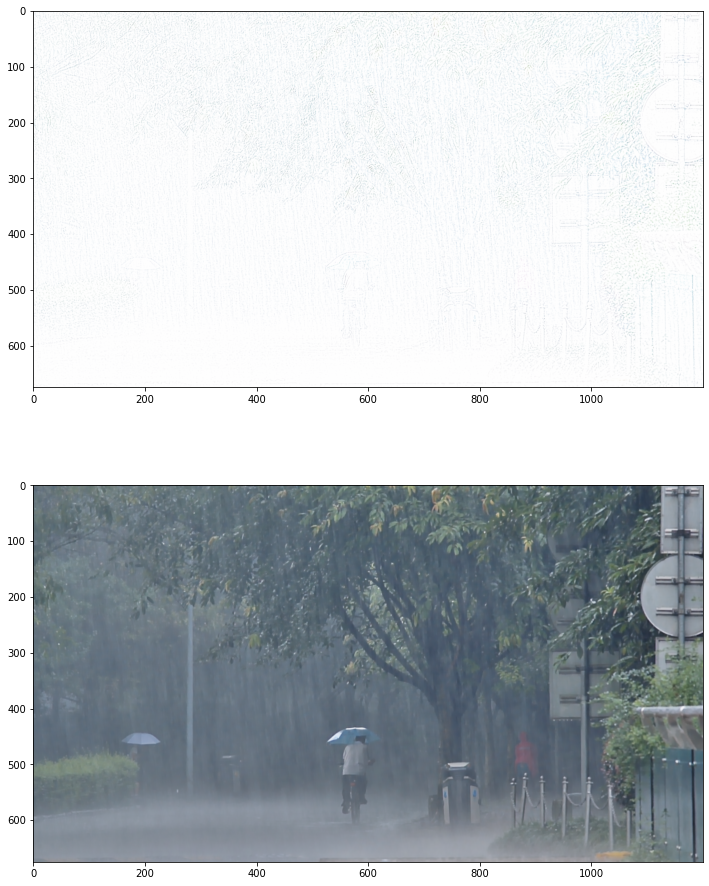

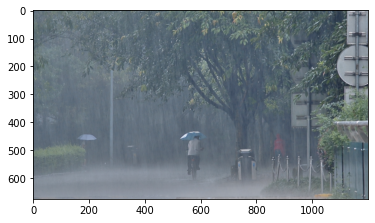

In [27]:
import matplotlib.pyplot as plt 
FNAME = 'input/input/004.png'
dehazed_image = cv2.imread(FNAME)
reflectance, illumination = decom_image(dehazed_image, net)

fig, axs = plt.subplots(2, figsize=(12, 16))
axs[0].imshow(reflectance)
axs[1].imshow(illumination, cmap='gray')

plt.figure()
plt.imshow(reflectance*illumination)
plt.show()

# Test model

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import numpy as np
from glob import glob

# --- Perceptual loss network  --- #
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3"
        }

    def output_features(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return list(output.values())

    def forward(self, pred_im, gt):
        loss = []
        pred_im_features = self.output_features(pred_im)
        gt_features = self.output_features(gt)
        for pred_im_feature, gt_feature in zip(pred_im_features, gt_features):
            loss.append(F.mse_loss(pred_im_feature, gt_feature))

        return sum(loss)/len(loss)

loss_network = LossNetwork(vgg_model)
loss_network.eval()

class DecomNet(nn.Module):
    def __init__(self, channel=64, kernel_size=4):
        super(DecomNet, self).__init__()
        # Shallow feature extraction
        self.net1_conv0 = nn.Conv2d(3, channel, kernel_size * 3,  padding=4, padding_mode='replicate')
        # Activated layers!
        self.net1_convs = nn.Sequential(nn.Conv2d(channel, channel, kernel_size, padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=1, padding_mode='replicate'),
                                        nn.ReLU())
        # Final recon layer
        self.net1_recon = nn.Conv2d(channel, 6, kernel_size, padding=1, padding_mode='replicate')

    def forward(self, input_im):
        #input_img = torch.cat((input_im, input_im), dim=1)
        feats0   = self.net1_conv0(input_img)
        featss   = self.net1_convs(feats0)
        outs     = self.net1_recon(featss)
        R        = torch.sigmoid(outs[:, 0:3, :, :])
        L        = torch.sigmoid(outs[:, 3:6, :, :])
        return R, L

def get_decom(trainable=True):
  net = DecomNet().cuda()
  ckpt_dict  = torch.load('decomp.tar') # , map_location=torch.device('cpu')
  net.load_state_dict(ckpt_dict)
  for p in net.parameters():
      p.requires_grad = trainable
  return net

def decom_image(image, net):
  test_low_img   = 2*cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 - 1
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(np.transpose(I_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  return R_low, I_low

!cp /content/drive/MyDrive/deweather2/decomp.tar .
net = get_decom()

for fname in glob('input/input/*.png'):
  image = cv2.imread(FNAME)
  reflectance, illumination = decom_image(dehazed_image)

In [ ]:
def decom_image(image):
  test_low_img   = 2*cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 - 1
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(np.transpose(I_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  return R_low, I_low

In [ ]:
net = get_decom()

In [ ]:
!cp /content/drive/MyDrive/deweather2/input.zip .
!unzip input.zip 

Archive:  input.zip
  inflating: input/get_list.py.ipynb  
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/natural.txt       
   creating: input/input/
   creating: input/.ipynb_checkpoints/
  inflating: input/input/348.png     
  inflating: input/input/412.png     
  inflating: input/input/374.png     
  inflating: input/input/360.png     
  inflating: input/input/406.png     
  inflating: input/input/638.png     
  inflating: input/input/176.png     
  inflating: input/input/610.png     
  inflating: input/input/604.png     
  inflating: input/input/162.png     
  inflating: input/input/002.png     
  inflating: input/input/016.png     
  inflating: input/input/228.png     
  inflating: input/input/566.png     
  inflating: input/input/200.png     
  inflating: input/input/214.png     
  inflating: input/input/572.png     
  inflating: input/input/599.png     
  inflating: input/input/215.png     
  inflating: input/input/573.png    

In [ ]:
import matplotlib.pyplot as plt 
FNAME = 'input/input/004.png'
dehazed_image = cv2.imread(FNAME)
reflectance, illumination = decom_image(dehazed_image)

fig, axs = plt.subplots(2, figsize=(12, 16))
axs[0].imshow(reflectance)
axs[1].imshow(illumination, cmap='gray')

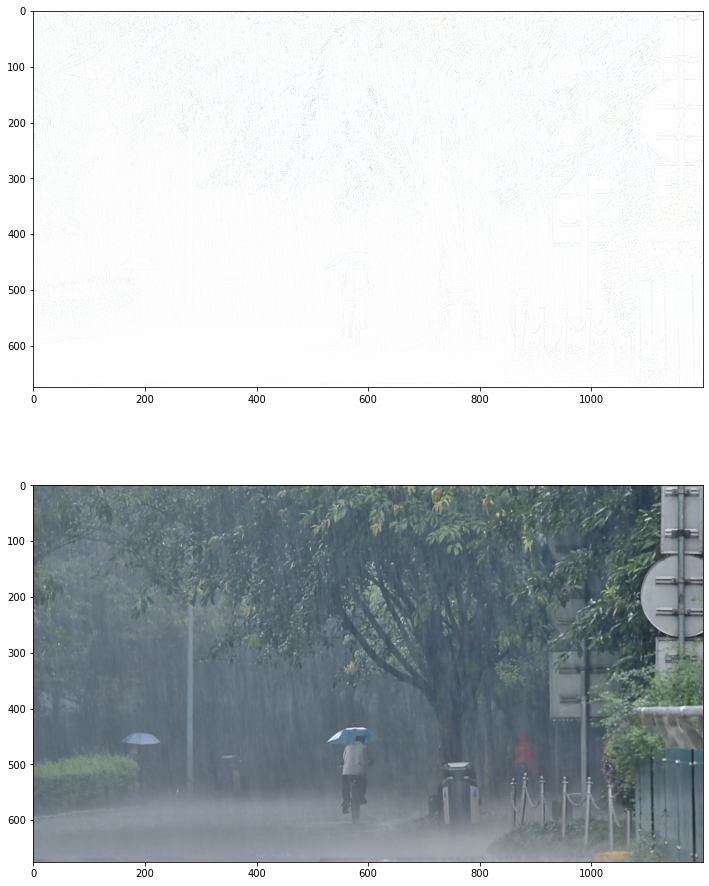

In [ ]:
import matplotlib.pyplot as plt 
FNAME = 'input/input/004.png'
dehazed_image = cv2.imread(FNAME)
reflectance, illumination = decom_image(dehazed_image)

fig, axs = plt.subplots(2, figsize=(12, 16))
axs[0].imshow(reflectance)
axs[1].imshow(illumination, cmap='gray')

In [ ]:
reflectance.shape

(681, 1024, 3)

In [ ]:
illumination.shape

(681, 1024, 3)

In [ ]:
cv2.imwrite?

# Stationary

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import numpy as np
from glob import glob

In [ ]:
ckpt_dict  = torch.load('decomp.tar')
net.load_state_dict(ckpt_dict)

<All keys matched successfully>

In [ ]:
def decom_image(image, net):
  test_low_img   = 2 * cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 - 1
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(np.transpose(I_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  return R_low, I_low

In [ ]:
!cp /content/drive/MyDrive/deweather2/input.zip .
!unzip input.zip

Archive:  input.zip
  inflating: input/get_list.py.ipynb  
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/natural.txt       
   creating: input/input/
   creating: input/.ipynb_checkpoints/
  inflating: input/input/348.png     
  inflating: input/input/412.png     
  inflating: input/input/374.png     
  inflating: input/input/360.png     
  inflating: input/input/406.png     
  inflating: input/input/638.png     
  inflating: input/input/176.png     
  inflating: input/input/610.png     
  inflating: input/input/604.png     
  inflating: input/input/162.png     
  inflating: input/input/002.png     
  inflating: input/input/016.png     
  inflating: input/input/228.png     
  inflating: input/input/566.png     
  inflating: input/input/200.png     
  inflating: input/input/214.png     
  inflating: input/input/572.png     
  inflating: input/input/599.png     
  inflating: input/input/215.png     
  inflating: input/input/573.png    

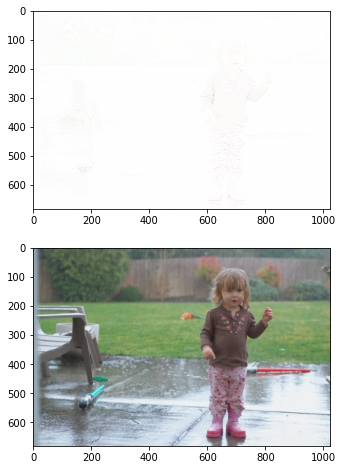

In [ ]:
import matplotlib.pyplot as plt 
FNAME = 'input/input/010.png'
dehazed_image = cv2.imread(FNAME)
reflectance, illumination = decom_image(dehazed_image, net)

fig, axs = plt.subplots(2, figsize=(16, 8))
axs[0].imshow(reflectance)
axs[1].imshow(illumination, cmap='gray')